<a href="https://colab.research.google.com/github/heehehe/kakao_arena_melon/blob/master/modeling_by_title" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###패키지 import & data 불러오기

In [1]:
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

Cloning into 'khaiii'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 957 (delta 25), reused 49 (delta 19), pack-reused 877
Receiving objects: 100% (957/957), 33.03 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (383/383), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-

In [2]:
### colab 사용 시 실행
from google.colab import drive
drive.mount('/content/gdrive/')
import os
os.chdir('gdrive/My Drive/Google Colaboratory/kakao_arena/kakao_arena_melon/src/ipynb')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import sys
sys.path.append('../')
from basic_utils import *

import re
from khaiii import KhaiiiApi
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
data_path = './../../../1_melon_playlist/data/'

train = pd.read_json(data_path+'train.json')
val = pd.read_json(data_path+'val.json')
# test = pd.read_json(data_path+'test.json')
# song_meta = load_json(data_path+'song_meta.json')
# genre_gn_all = pd.read_json(data_path+'genre_gn_all.json', typ = 'series')

### make_file.ipynb 내에서 만들어진 tag_song_dict / song_tag_dict 불러오기
# tag_song_dict = load_json(data_path+'tag_song_dict_no0.json')
# song_tag_dict = load_json(data_path+'song_tag_dict.json')

In [ ]:
train.head(2)

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000


#### tag 형태소 분석

In [ ]:
print('train에서 title 존재 데이터 개수 : {}개 ({}%)'.format(len(train[train['plylst_title']!='']), len(train[train['plylst_title']!=''])/len(train)*100))
print('val에서 title 존재 데이터 개수   : {}개 ({}%)'.format(len(val[val['plylst_title']!='']),     len(val[val['plylst_title']!=''])/len(val)*100))
print('test에서 title 존재 데이터 개수  : {}개 ({}%)'.format(len(test[test['plylst_title']!='']),   len(test[test['plylst_title']!=''])/len(test)*100))

train에서 title 존재 데이터 개수 : 115071개 (100.0%)
val에서 title 존재 데이터 개수   : 4373개 (19.00065174885944%)
test에서 title 존재 데이터 개수  : 2041개 (19.00372439478585%)


In [ ]:
def flatten(df_col):
    # nested list 풀기
    list_of_list = df_col.values.tolist()
    flatten = [j for i in list_of_list for j in i]
    return flatten

# def get_all(df) -> List:
#     tag_list = df['tags'].values.tolist()
#     tag_list = flatten(tag_list)
#     return tag_list

def do_khaiii(data):
    api = KhaiiiApi()
    morphs_prep = []
    for d in data:
        try:
            for word in api.analyze(d):
                for w in word.morphs:
                    if len(w.lex) > 1 or w.tag not in ['ETM','ETN','XSA','JX','VV']:
                        morphs_prep.append((w.lex, w.tag))
        except:
            pass # 비어있는 경우
    gc.collect()
    return morphs_prep

# api = KhaiiiApi()
# tag_morphs = []
# for tag in train['tags']:
#     for t in tag:
#         try:
#             for word in api.analyze(t):
#                 for w in word.morphs:
#                     tag_morphs.append((w.lex, w.tag))
#         except:
#             pass # 비어있는 경우

def do_khaiii_col(data):
    api = KhaiiiApi()
    morphs_prep = ['']*len(data)
    for i,d in enumerate(data):
        try:
            for word in api.analyze(d):
                for w in word.morphs:
                    if len(w.lex) > 1 or w.tag not in ['ETM','ETN','XSA','JX','VV']:
                        morphs_prep[i] = (w.lex, w.tag)
        except:
            pass # 비어있는 경우
    gc.collect()
    return morphs_prep

In [ ]:
tags_list = flatten(train['tags'])
songs_list = flatten(train['songs'])

In [ ]:
print(len(tags_list))
print(len(songs_list))

476331
5285871


In [ ]:
tag_morphs = []
for tag in tqdm(tags_list):
    tag_morphs.extend(do_khaiii(tag))

In [ ]:
len(tag_morphs)

722860

In [ ]:
# Counter([t[0] for t in tag_morphs]).most_common()
Counter(tag_morphs).most_common()[:30]

[(('ㄴ', 'ETM'), 26970),
 (('하', 'XSA'), 21926),
 (('기분', 'NNG'), 17443),
 (('전환', 'NNG'), 16543),
 (('감성', 'NNG'), 14411),
 (('휴식', 'NNG'), 11385),
 (('발라드', 'NNG'), 10798),
 (('잔잔', 'XR'), 10526),
 (('드라이브', 'NNG'), 10212),
 (('힐링', 'NNG'), 9871),
 (('새벽', 'NNG'), 9422),
 (('사랑', 'NNG'), 9418),
 (('힙합', 'NNG'), 8983),
 (('밤', 'NNG'), 8765),
 (('음악', 'NNG'), 8649),
 (('는', 'JX'), 8462),
 (('카페', 'NNG'), 7776),
 (('팝', 'NNG'), 7373),
 (('추억', 'NNG'), 6841),
 (('ㅁ', 'ETN'), 6388),
 (('매장', 'NNG'), 6124),
 (('인디', 'NNG'), 5594),
 (('이별', 'NNG'), 5505),
 (('설', 'NNP'), 5090),
 (('나', 'VV'), 5027),
 (('신', 'NNG'), 4988),
 (('레', 'VV'), 4912),
 (('여행', 'NNG'), 4857),
 (('회상', 'NNG'), 4736),
 (('겨울', 'NNG'), 4727)]

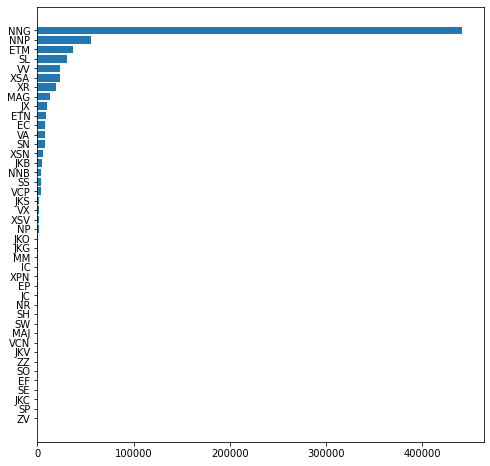

In [ ]:
tag_morphs_counter = Counter([t[1] for t in tag_morphs]).most_common()
tag_morphs_list = [t[0] for t in tag_morphs_counter]
tag_morphs_cnt = [t[1] for t in tag_morphs_counter]

plt.figure(figsize=(8,8))
plt.barh(tag_morphs_list[::-1], tag_morphs_cnt[::-1])
plt.show()

In [ ]:
tag_morphs_counter

In [ ]:
api = KhaiiiApi()

tag_morphs_prep = []
for tag in train['tags']:
    for t in tag:
        try:
            for word in api.analyze(t):
                for w in word.morphs:
                    if len(w.lex) > 1 or w.tag not in ['ETM','ETN','XSA','JX','VV']:
                        tag_morphs_prep.append((w.lex, w.tag))
        except:
            pass # 비어있는 경우

In [ ]:
len(tag_morphs_prep)

623244

In [ ]:
Counter(tag_morphs_prep).most_common()[:30]

[(('기분', 'NNG'), 17443),
 (('전환', 'NNG'), 16543),
 (('감성', 'NNG'), 14411),
 (('휴식', 'NNG'), 11385),
 (('발라드', 'NNG'), 10798),
 (('잔잔', 'XR'), 10526),
 (('드라이브', 'NNG'), 10212),
 (('힐링', 'NNG'), 9871),
 (('새벽', 'NNG'), 9422),
 (('사랑', 'NNG'), 9418),
 (('힙합', 'NNG'), 8983),
 (('밤', 'NNG'), 8765),
 (('음악', 'NNG'), 8649),
 (('카페', 'NNG'), 7776),
 (('팝', 'NNG'), 7373),
 (('추억', 'NNG'), 6841),
 (('매장', 'NNG'), 6124),
 (('인디', 'NNG'), 5594),
 (('이별', 'NNG'), 5505),
 (('설', 'NNP'), 5090),
 (('신', 'NNG'), 4988),
 (('여행', 'NNG'), 4857),
 (('회상', 'NNG'), 4736),
 (('겨울', 'NNG'), 4727),
 (('여름', 'NNG'), 4358),
 (('가을', 'NNG'), 4169),
 (('비', 'NNG'), 4166),
 (('스트레스', 'NNG'), 4163),
 (('노래', 'NNG'), 4077),
 (('락', 'MAG'), 4026)]

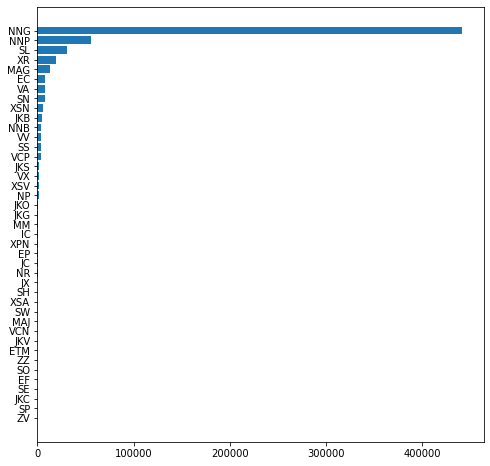

In [ ]:
tag_morphs_counter = Counter([t[1] for t in tag_morphs_prep]).most_common()
tag_morphs_list = [t[0] for t in tag_morphs_counter]
tag_morphs_cnt = [t[1] for t in tag_morphs_counter]

plt.figure(figsize=(8,8))
plt.barh(tag_morphs_list[::-1], tag_morphs_cnt[::-1])
plt.show()

In [ ]:
tag_morphs_counter

[('NNG', 441528),
 ('NNP', 55476),
 ('SL', 31299),
 ('XR', 19608),
 ('MAG', 12875),
 ('EC', 8372),
 ('VA', 8109),
 ('SN', 7700),
 ('XSN', 5605),
 ('JKB', 4754),
 ('NNB', 3702),
 ('VV', 3687),
 ('SS', 3369),
 ('VCP', 3337),
 ('JKS', 2194),
 ('VX', 2095),
 ('XSV', 1921),
 ('NP', 1568),
 ('JKO', 989),
 ('JKG', 945),
 ('MM', 904),
 ('IC', 853),
 ('XPN', 664),
 ('EP', 530),
 ('JC', 401),
 ('NR', 193),
 ('JX', 138),
 ('SH', 99),
 ('XSA', 89),
 ('SW', 66),
 ('MAJ', 41),
 ('VCN', 23),
 ('JKV', 21),
 ('ETM', 17),
 ('ZZ', 16),
 ('SO', 14),
 ('EF', 12),
 ('SE', 11),
 ('JKC', 10),
 ('SP', 6),
 ('ZV', 3)]

In [ ]:
# morphs_all = ['']*len(train)

# for i,title in enumerate(train['plylst_title']):
#     morphs = []
#     try:
#         for word in api.analyze(title):
#             for morph in word.morphs:
#                 if morph.tag in ['NNG','NNP']:#,'ETM','SL','VV','XSA','XR','MAG','JX','ETN']:
#                 # if morph.tag not in ['VCP','VCN','EP']
#                     morphs.append(morph.lex)
#         morphs_all[i] = morphs
#     except: pass

#### train에서 title로 태그 추출

In [19]:
api = KhaiiiApi()

def do_khaiii_col(data):
    morphs_prep = ['']*len(data)
    for i,d in enumerate(tqdm(data)):
        list_add = []
        try:
            for word in api.analyze(d):
                for w in word.morphs:
                    # if w.tag in ['NNG','NNP','SL','XR']:
                    # if (len(w.lex) > 1 or w.tag not in ['ETM','ETN','JX','VV','VA','VCP']) \
                    if len(w.lex) > 1\
                       and w.tag not in ['NP','JKS','JKC','JKG','JKO','JKB','JKV','JKQ','JX','JC',\
                                         'EP','EF','EC','SF','SP','SS','SE','SO','XSA']\
                       and w.lex not in ['ㅋ','노래','음악','곡','월']:
                        list_add.append((w.lex, w.tag))
        except:
            pass # 비어있는 경우
        morphs_prep[i] = list_add
    gc.collect()
    return morphs_prep

In [20]:
title_khaiii = do_khaiii_col(train['plylst_title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")) #A-Za-z

100%|██████████| 115071/115071 [00:56<00:00, 2028.18it/s]


In [7]:
# 태그 없애기
title_khaiii2 = title_khaiii.copy()
for i,title in enumerate(title_khaiii):
    title_khaiii2[i] = [t[0] for t in title]

['요즘', '말', '이']

In [21]:
train['title2tags'] = title_khaiii

In [22]:
train[['plylst_title','tags','title2tags']].head(30)

,plylst_title,tags,title2tags
0,여행같은 음악,[락],"[(여행, NNG)]"
1,요즘 너 말야,"[추억, 회상]","[(요즘, NNG)]"
2,"편하게, 잔잔하게 들을 수 있는 곡.-","[까페, 잔잔한]","[(편하, VA), (잔잔, XR)]"
3,크리스마스 분위기에 흠뻑 취하고 싶을때,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...","[(크리스마스, NNG), (분위기, NNG), (흠뻑, MAG), (취하, VV)]"
4,추억의 노래 ㅋ,[댄스],"[(추억, NNG)]"
5,2017 Pop Trend,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",[]
6,짝사랑..고백..사랑..이별..슬픔.. 감성을 자극하는곡들!,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]","[(짝사랑, NNG), (백사랑이별슬픔, NNG), (감성, NNG), (자극, N..."
7,멍청이.. 내맘도 몰라.,"[잔잔한, 추억, 회상]","[(멍청, NNG), (모르, VV)]"
8,DANCING IN THE MOON-LIGHT .01,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]",[]
9,[록/메탈] Written by 이일우,"[록, Metal, 이일우, M에센셜, 메탈, Rock, 락]","[(록메탈, NNP), (이일우, NNP)]"


In [ ]:
sum_of_intersect = 0
for i in tqdm(train.index):
    tags = set(train.loc[i]['tags'])
    tags_from_title = set(train.loc[i]['title2tags'])
    sum_of_intersect += len(tags & tags_from_title) / len(tags)
    # if tags & tags_from_title:
    #     print(tags & tags_from_title)
sum_of_intersect / len(train)

100%|██████████| 115071/115071 [00:55<00:00, 2064.90it/s]


0.12910328290574238

In [ ]:
def add_tags(data):
    title_khaiii = do_khaiii_col(data['plylst_title'])
    title_khaiii2 = ['']*len(data)
    for i,title in enumerate(tqdm(title_khaiii)):
        title_khaiii2[i] = [t[0] for t in title]
    data['tags_new'] = data['tags'] + title_khaiii2
    tn_list = []
    for tn in tqdm(data['tags_new']):
        tn_list.append(list(set(tn)))
    data['tags_new'] = tn_list
    return data

### validation에서 title로 태그 추출

In [ ]:
no_tag, no_song, yes_index, no_both = check_target_type(val)

노래 O 태그 X : 9661개
노래 X 태그 O : 2630개
노래 O 태그 O : 8975개
노래 X 태그 X : 1749개


In [ ]:
# val2, 4에만 제목 존재
val2 = val[val.index.isin(no_song)]
val4 = val[val.index.isin(no_both)]

In [ ]:
val2_new = add_tags(val2)
val4_new = add_tags(val4)

100%|██████████| 1749/1749 [00:00<00:00, 413240.07it/s]


In [ ]:
val2_new.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,tags_new
8,[스트레스],80810,리듬타면서 빡시게 운동하자!!!(스트레스 날리자):},[],127,2017-02-09 17:33:45.000,"[빡시, 리, 운동, 하, 스트레스, 날리자, 듬타]"
17,[생각나],2380,다시 생각나는 그 사람,[],6,2016-03-19 23:53:20.000,"[생각나, 다시, 그, 사람]"
20,"[피아노, 이루마, 메로디]",149069,불면증엔 아름다운 뉴에이지 곡들,[],11,2019-12-15 19:15:21.000,"[피아노, 뉴에이, 곡들, 불면증, 이루마, 아름답, 지, 메로디]"
40,"[발렌타인데이, 달달한, 사랑노래, 고백]",80682,발렌타인 데이 -달콤한 초콜릿 매장 음악,[],27,2019-05-13 15:46:52.000,"[사랑노래, 발렌타인데이, 이, 데이, 음악, 고백, 초콜릿, 달콤, 발렌타, 달달..."
42,[새벽],8253,하루 끝 잔잔한 노래로 기분 좋게 잠에 들기,[],8,2019-06-08 23:48:41.000,"[잔잔, 노래, 기분, 새벽, 끝, 하루, 잠]"


In [ ]:
val4_new.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,tags_new
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000,"[앨리스테, 이블]"
9,[],142007,기분 좋은 재즈와 함께 만드는 달달한 하루,[],0,2015-06-22 09:11:02.000,"[달, 재즈, 기분, 하루, 함께, 만들]"
35,[],65114,"■■■■ 사랑,그리고이별 ■■■■",[],6,2010-10-27 10:34:34.000,"[리, ■, 고이별, ■■■■, 사랑, 그, ■■■]"
57,[],87700,마쉬멜로우같은 멜로우한 음악,[],6,2016-01-14 10:19:30.000,"[멜로우한, 멜로, 음악, 우, 마쉬]"
71,[],35271,공부와 독서를 위한 #Newage,[],10,2020-01-17 15:46:20.000,"[#, 공부, 독서, Newage, 위하]"
